In [ ]:
# using Pkg
# Pkg.add("CSV")
# Pkg.add("DataFrames")
# Pkg.add("Dates")
# Pkg.add("Plots")

In [1]:
using CSV
using DataFrames, Statistics, Plots
using Dates
using StatsPlots

In [2]:
# upload Divvy datasets from csv
df1 = DataFrame(CSV.File("data/202212-divvy-tripdata.csv"));
df2 = DataFrame(CSV.File("data/202301-divvy-tripdata.csv"));
df3 = DataFrame(CSV.File("data/202302-divvy-tripdata.csv"));

In [3]:
# first(df, 3)
describe(df1)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,ride_id,,0000038F578A7278,,FFFFD13DCFDD50D1,0,String31
2,rideable_type,,classic_bike,,electric_bike,0,String15
3,started_at,,2022-12-01 00:01:22,,2022-12-31 23:59:26,0,String31
4,ended_at,,2022-12-01 00:03:41,,2023-01-02 04:56:45,0,String31
5,start_station_name,,2112 W Peterson Ave,,Yates Blvd & 93rd St,29283,"Union{Missing, String}"
6,start_station_id,,021320,,chargingstx5,29283,"Union{Missing, String15}"
7,end_station_name,,2112 W Peterson Ave,,Yates Blvd & 75th St,31158,"Union{Missing, String}"
8,end_station_id,,021320,,chargingstx5,31158,"Union{Missing, String}"
9,start_lat,41.9008,41.6485,41.8964,42.07,0,Float64


In [4]:
for df in [df1, df2, df3]
    println(names(df))
end

["ride_id", "rideable_type", "started_at", "ended_at", "start_station_name", "start_station_id", "end_station_name", "end_station_id", "start_lat", "start_lng", "end_lat", "end_lng", "member_casual"]
["ride_id", "rideable_type", "started_at", "ended_at", "start_station_name", "start_station_id", "end_station_name", "end_station_id", "start_lat", "start_lng", "end_lat", "end_lng", "member_casual"]
["ride_id", "rideable_type", "started_at", "ended_at", "start_station_name", "start_station_id", "end_station_name", "end_station_id", "start_lat", "start_lng", "end_lat", "end_lng", "member_casual"]


In [22]:
df = vcat(df1, df2, df3);
println(nrow(df))
println(nrow(df1) + nrow(df2) + nrow(df3))

562552
562552


In [6]:
println(unique(df.member_casual))
println(unique(df.rideable_type))

String7["member", "casual"]


String15["electric_bike", "classic_bike", "docked_bike"]


In [23]:
# drop rows with missing values
dropmissing!(df)
nrow(df)

433247

In [24]:
transform!(df, :started_at => ByRow(x -> Date(x, "yyyy-mm-dd HH:MM:SS")) => :date);
transform!(df, :date => ByRow(x -> dayname(x)) => :day_of_week);

In [25]:
func = ByRow((started_at, ended_at) -> div(DateTime(ended_at, "yyyy-mm-dd HH:MM:SS") - DateTime(started_at, "yyyy-mm-dd HH:MM:SS"), 60000))
transform!(df, [:started_at, :ended_at] => func => :ride_length);
# convert to int
df.ride_length = Dates.value.(df.ride_length) 

433247-element Vector{Int64}:
  9
 26
 12
 29
 14
  9
 17
  8
 18
 13
  ⋮
 14
 15
 18
  7
 10
 10
 15
 16
 12

In [26]:
filter!(row -> row.ride_length > 0, df)
nrow(df)

422933

In [11]:
println(combine(groupby(df, :member_casual), :ride_id => length))
println()
println(describe(df, cols=:ride_length))
println()
println(combine(groupby(df, :member_casual), :ride_length => mean => :Mean))

2×2 DataFrame
 Row │ member_casual  ride_id_length 
     │ String7        Int64          
─────┼───────────────────────────────
   1 │ member                 330791
   2 │ casual                  92142

1×7 DataFrame
 Row │ variable     mean     min    median   max    nmissing  eltype   
     │ Symbol       Float64  Int64  Float64  Int64  Int64     DataType 
─────┼─────────────────────────────────────────────────────────────────
   1 │ ride_length  11.2075      1      7.0   1497         0  Int64

2×2 DataFrame
 Row │ member_casual  Mean     
     │ String7        Float64  
─────┼─────────────────────────
   1 │ member          9.97173
   2 │ casual         15.6438


In [36]:
combine(groupby(df, [:member_casual, :day_of_week]), :ride_length => mean => :Mean)

Row,member_casual,day_of_week,Mean
,String7,String,Float64
1,member,Monday,9.73545
2,casual,Sunday,20.2438
3,member,Tuesday,9.59223
4,casual,Wednesday,13.3108
5,member,Friday,9.89847
6,member,Wednesday,9.70465
7,member,Thursday,9.51383
8,member,Saturday,10.7476
9,casual,Saturday,17.5936


In [37]:
combine(groupby(df, [:member_casual, :day_of_week]), :ride_length => length => :records_count)

Row,member_casual,day_of_week,records_count
,String7,String,Int64
1,member,Monday,50641
2,casual,Sunday,16290
3,member,Tuesday,62432
4,casual,Wednesday,11584
5,member,Friday,42964
6,member,Wednesday,51071
7,member,Thursday,51661
8,member,Saturday,35902
9,casual,Saturday,14276


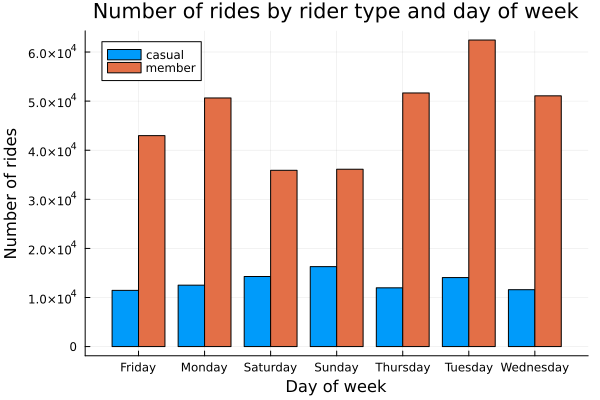

In [40]:
vis_df = combine(groupby(df, [:member_casual, :day_of_week]), :ride_length => length => :records_count)

groupedbar(
    vis_df.day_of_week, vis_df.records_count, 
    group = vis_df.member_casual, 
    xlabel = "Day of week", ylabel = "Number of rides", 
    title = "Number of rides by rider type and day of week"
)

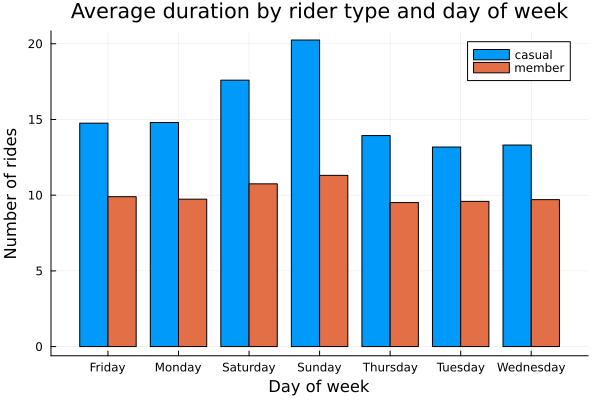

In [41]:
vis_df = combine(groupby(df, [:member_casual, :day_of_week]), :ride_length => mean => :length_mean)

groupedbar(
    vis_df.day_of_week, vis_df.length_mean, 
    group = vis_df.member_casual, 
    xlabel = "Day of week", ylabel = "Number of rides", 
    title = "Average duration by rider type and day of week"
)